In [38]:
# Import libraries.
import math
import torch
import requests
from torch import nn
from PIL import Image
import ipywidgets as widgets
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torchvision.models import resnet50
from IPython.display import display, clear_output

torch.set_grad_enabled(False);
%config InlineBackend.figure_format = 'retina'

In [39]:
# Load the a pre-trained DETR model from TorchHub. Change it to whichever of the four models you want to test.
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


In [40]:
# Specify COCO classes.
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]
# Specify the colors for the bounding boxes.
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [41]:
# Normalize the input image.
transform = T.Compose([T.Resize(800), T.ToTensor(), T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# Post-process the the output bounding boxes.
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)
def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [42]:
# Plot the images and the detected objects.
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [43]:
# Get a PIL image.
url = 'https://thumbs.dreamstime.com/b/cute-orange-vagrant-little-cat-hiding-grass-having-hidden-agenda-cute-orange-vagrant-little-cat-hiding-grass-having-103862587.jpg'
# url = 'https://farm4.staticflickr.com/3094/3354108024_980a8a1bdf_z.jpg'
im = Image.open(requests.get(url, stream=True).raw)

In [44]:
# Normalize the input image.
img = transform(im).unsqueeze(0)
# Propagate the image through the model.
outputs = model(img)
# Ignore non-object predictions and objects with a class confidence of less than the desired threshold. Change the threshold as needed.
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9
# Rescale the bounding boxes.
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

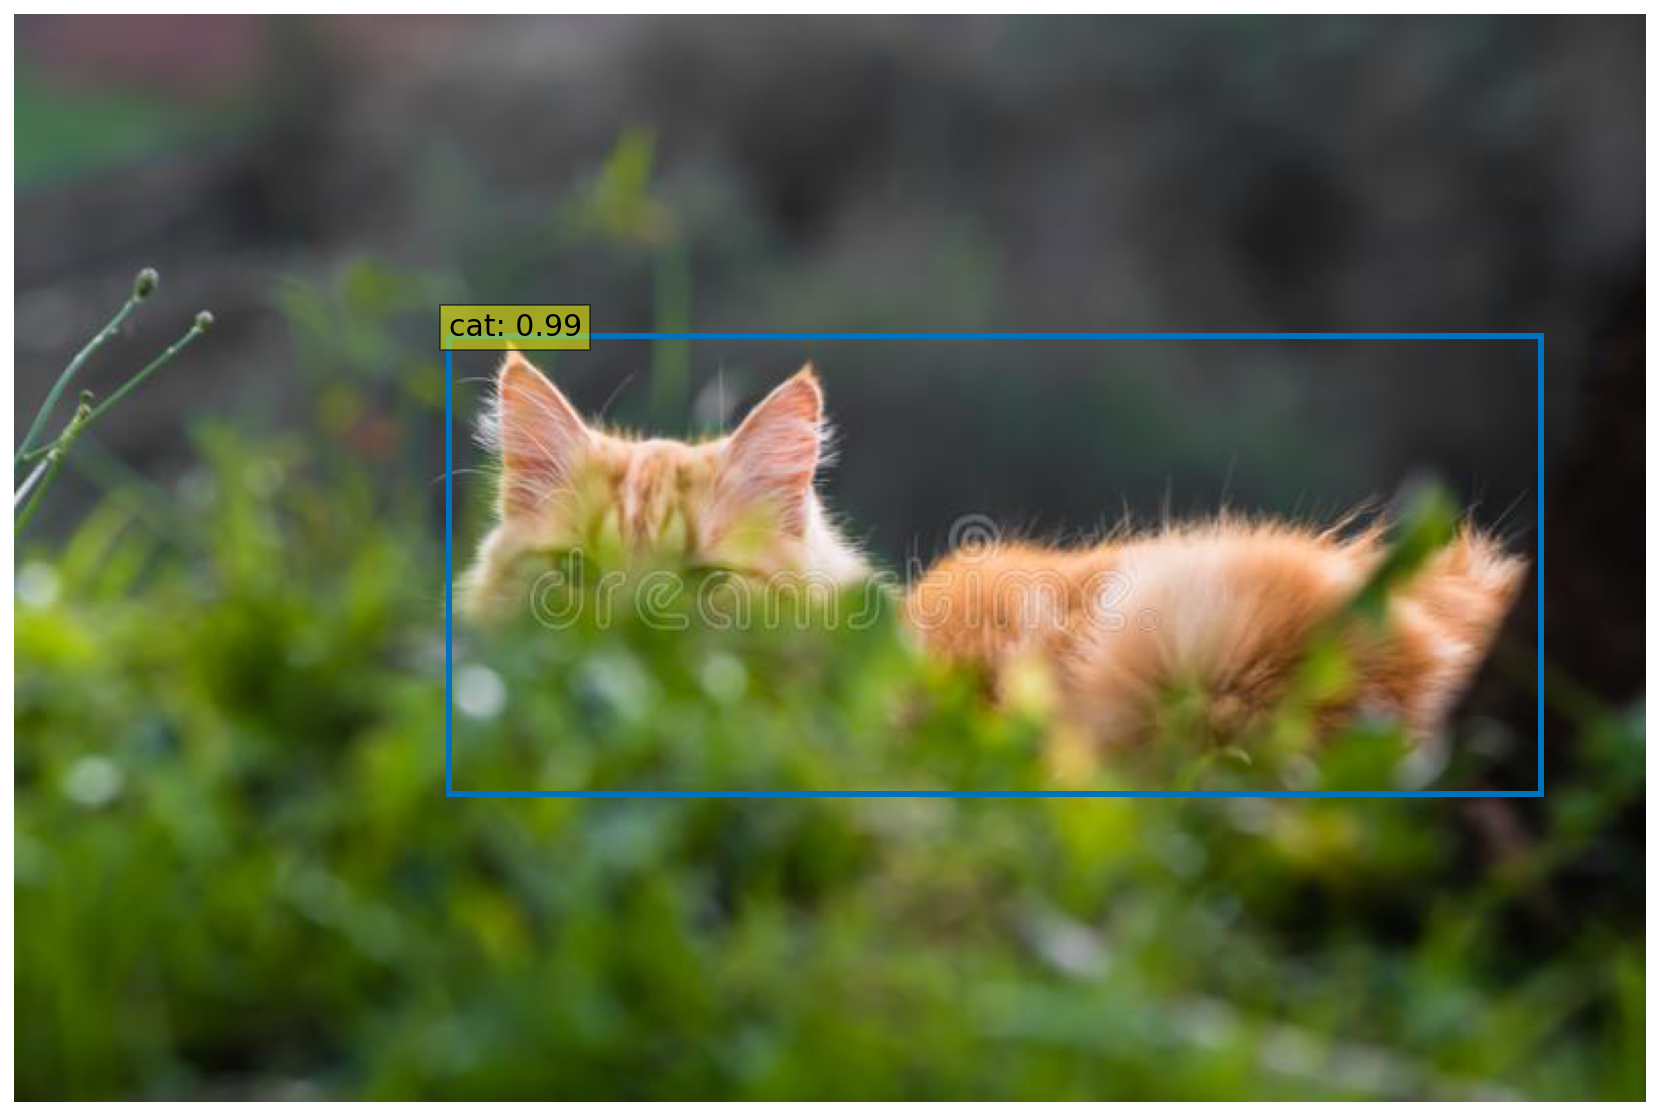

In [45]:
# Visualize the predictions of the DETR on the input image.
plot_results(im, probas[keep], bboxes_scaled)

In [46]:
class SelfAttentionVisualizer:
    def __init__(self, model, transform):
        self.model = model
        self.transform = transform
        self.url = ""
        self.cur_url = None
        self.pil_img = None
        self.tensor_img = None
        self.conv_features = None
        self.enc_attn_weights = None
        self.dec_attn_weights = None
        self.setup_widgets()
    def setup_widgets(self):
        self.sliders = [
            widgets.Text(
                value='https://thumbs.dreamstime.com/b/cute-orange-vagrant-little-cat-hiding-grass-having-hidden-agenda-cute-orange-vagrant-little-cat-hiding-grass-having-103862587.jpg',
                placeholder='Enter URL',
                description='URL:',
                disabled=False,
                continuous_update=False,
                layout=widgets.Layout(width='100%')
            ),
            widgets.FloatSlider(min=0, max=0.99,
                        step=0.02, description='X-Coordinate', value=0.72,
                        continuous_update=False,
                        layout=widgets.Layout(width='50%')
                        ),
            widgets.FloatSlider(min=0, max=0.99,
                        step=0.02, description='Y-Coordinate', value=0.40,
                        continuous_update=False,
                        layout=widgets.Layout(width='50%')),
            widgets.Checkbox(
              value=False,
              description='Attention Direction',
              disabled=False,
              indent=False,
              layout=widgets.Layout(width='50%'),
          ),
            widgets.Checkbox(
              value=True,
              description='Attention Marker',
              disabled=False,
              indent=False,
              layout=widgets.Layout(width='50%'),
          )
        ]
        self.o = widgets.Output()
    def compute_features(self, img):
        model = self.model
        # Store the outputs via up-values.
        conv_features, enc_attn_weights, dec_attn_weights = [], [], []
        hooks = [
            model.backbone[-2].register_forward_hook(
                lambda self, input, output: conv_features.append(output)
            ),
            model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
                lambda self, input, output: enc_attn_weights.append(output[1])
            ),
            model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
                lambda self, input, output: dec_attn_weights.append(output[1])
            ),
        ]
        # Propogate the input image through the model.
        outputs = model(img)
        for hook in hooks:
            hook.remove()
        self.conv_features = conv_features[0]
        self.dec_attn_weights = dec_attn_weights[0]
        # Get the HxW shape of the feature maps of the CNN.
        shape = self.conv_features['0'].tensors.shape[-2:]
        # Reshape the self-attention to a more interpretable shape.
        self.enc_attn_weights = enc_attn_weights[0].reshape(shape + shape)
    def compute_on_image(self, url):
        if url != self.url:
            self.url = url
            self.pil_img = Image.open(requests.get(url, stream=True).raw)
            self.tensor_img = self.transform(self.pil_img).unsqueeze(0)
            self.compute_features(self.tensor_img)  
    def update_chart(self, change):
        with self.o:
            clear_output()
            url, j, i, sattn_dir, sattn_dot = [s.value for s in self.sliders]
            fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(9, 4))
            self.compute_on_image(url)
            # Convert reference points to absolute coordinates.
            j = int(j * self.tensor_img.shape[-1])
            i = int(i * self.tensor_img.shape[-2])
            scale = self.pil_img.height / self.tensor_img.shape[-2]
            # Compute the downsampling factor for the model.
            sattn = self.enc_attn_weights
            fact = 2 ** round(math.log2(self.tensor_img.shape[-1] / sattn.shape[-1]))
            # Round the position at the downsampling factor.
            x = ((j // fact) + 0.5) * fact
            y = ((i // fact) + 0.5) * fact
            axs[0].imshow(self.pil_img)
            axs[0].axis('off')
            axs[0].add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))
            idx = (i // fact, j // fact)
            if sattn_dir:
                sattn_map = sattn[idx[0], idx[1], ...]
            else:
                sattn_map = sattn[..., idx[0], idx[1]]
            axs[1].imshow(sattn_map, cmap='cividis', interpolation='nearest')
            if sattn_dot:
                axs[1].add_patch(plt.Circle((idx[1],idx[0]), 1, color='r'))
            axs[1].axis('off')
            axs[1].set_title(f'self-attention{(i, j)}')
            plt.show()
    def run(self):
      for s in self.sliders:
          s.observe(self.update_chart, 'value')
      self.update_chart(None)
      url, x, y, d, sattn_d = self.sliders
      res = widgets.VBox(
      [
          url,
          widgets.HBox([x, y]),
          widgets.HBox([d, sattn_d]),
          self.o
      ])
      return res

In [47]:
w = SelfAttentionVisualizer(model, transform)
w.run()

In [48]:
# Store the outputs via up-values.
conv_features, enc_attn_weights, dec_attn_weights = [], [], []
hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]
# Propogate the input image through the model.
outputs = model(img)
for hook in hooks:
    hook.remove()
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

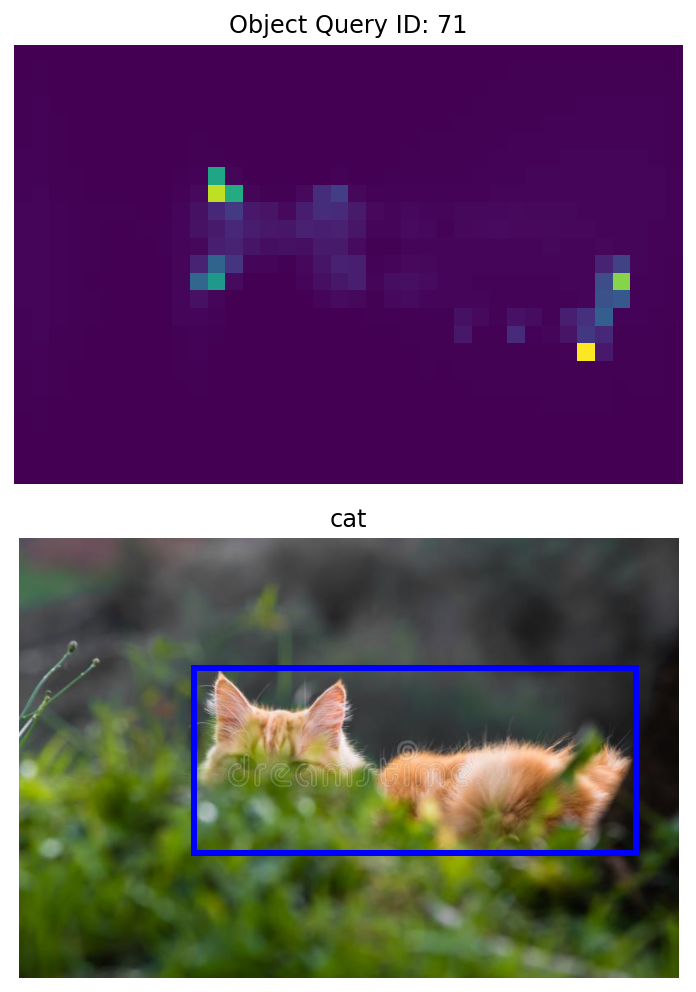

In [49]:
# Get the shape of the feature map.
h, w = conv_features['0'].tensors.shape[-2:]
fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7), squeeze=False)
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(dec_attn_weights[0, idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'Object Query ID: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()